#### **About**

Dataset https://www.kaggle.com/datasets/hugomathien/soccer

- What do we do with that fag validation and test fucking set



# Changes to do:
- Use difference rather than ratio, also for RF
  - Mention and show before and after
  - What is with highly correlated variables?
    - Omit for logistic regression
    - leave for random forest

- Train, Test, Validation
- What to do? Really incorporate it?
  - TEST ONE LAST TIME WHAT CHANGES AND LEAVE IT!
    - but must rakte TRAIN + TEST for Model training then

#### Load required package

In [5]:
# Import packages

import sqlite3
import os
import pandas as pd
import numpy as np
from google.colab import drive
import time
import datetime
drive.mount('content/')


Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


In [6]:

! ls -l 
#ColabNotebooks/

total 8
drwx------ 6 root root 4096 Jan 20 08:22 content
drwxr-xr-x 1 root root 4096 Jan 18 14:55 sample_data


In [7]:
con = sqlite3.connect("content/MyDrive/CAS_ADS/M3_ML/Project_M3/database.sqlite")
cur = con.cursor()

# database.sqlite
# Country
# League
# Match
# Player
# Player_Attributes
# Team
# Team_Attributes

In [8]:
pd.set_option('max_columns', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

##### **Database sqlite**


*   Join the tables
*   Explore data
*   Chose latest season
*   Delete unnecessary columns




In [9]:
def assign_result(row):
  if row['home_team_goal'] > row['away_team_goal']:
    return "home"
  elif row['home_team_goal'] == row['away_team_goal']:
    return "draw"
  else:
    return "away"

def assign_points_home(row):
  if row['home_team_goal'] > row['away_team_goal']:
    return 3
  elif row['home_team_goal'] == row['away_team_goal']:
    return 1
  else:
    return 0

def assign_points_away(row):
  if row['home_team_goal'] > row['away_team_goal']:
    return 0
  elif row['home_team_goal'] == row['away_team_goal']:
    return 1
  else:
    return 3

def assign_value_from_list(row,value_list):
  return value_list[row['date_index']]


In [10]:
cur.execute(
    '''SELECT
        Match.id,
        Match.date,
        Match.season,
        Match.stage,
        Match.country_id,
        Country.name AS Country_Name,
        Match.league_id,
        League.name AS League_Name,
        Match.home_team_api_id,
        HT.team_long_name AS HT_long_name,
        Match.away_team_api_id,
        AT.team_long_name AS AT_long_name,
        home_team_goal,
        away_team_goal,
        home_player_1,
        home_player_2,
        home_player_3,
        home_player_4,
        home_player_5,
        home_player_6,
        home_player_7,
        home_player_8,
        home_player_9,
        home_player_10,
        home_player_11,
        away_player_1,
        away_player_2,
        away_player_3,
        away_player_4,
        away_player_5,
        away_player_6,
        away_player_7,
        away_player_8,
        away_player_9,
        away_player_10,
        away_player_11,
        B365H,
        B365D,
        B365A
    from Match
    LEFT JOIN Country ON Match.country_id = Country.id
    LEFT JOIN League ON Match.league_id = League.id
    LEFT JOIN Team AS HT ON HT.team_api_id = Match.home_team_api_id
    LEFT JOIN Team AS AT ON AT.team_api_id = Match.away_team_api_id
    WHERE 1 = 1
    AND Country.Name in ("Italy","Spain")
    AND Match.season in ("2014/2015","2015/2016")'''

)
rows = cur.fetchall()
names = list(map(lambda x: x[0], cur.description))
df  = pd.DataFrame(rows, columns = names)

df['date'] = pd.to_datetime(df['date'])
df['result'] = df.apply(lambda row: assign_result(row), axis=1)
df['home_points'] = df.apply(lambda row: assign_points_home(row), axis=1)
df['away_points'] = df.apply(lambda row: assign_points_away(row), axis=1)
df['year'] = [x[:4] for x in df['season']]

In [11]:
# Prepare list with player ID for dummy table with attributes
unique_player_ids = df["home_player_1"].unique()

for i in range(df.columns.get_loc("home_player_2"), df.columns.get_loc("away_player_11")+1):
  unique_player_ids_temp = df.iloc[:,i].unique()
  unique_player_ids = np.append(unique_player_ids, unique_player_ids_temp) 

unique_player_ids = np.unique(unique_player_ids)
unique_player_ids = unique_player_ids[~np.isnan(unique_player_ids)]


####Player Attributes

- player_api_id
- overall_rating
- potential (probably gets more relevant the longer the season)

Need to transform everything....

Possible imporvements:
- better Loop for NA Fillings
- already restrict SQL with sub-query for players

In [12]:
cur.execute(
    '''SELECT
        player_api_id,
        date,
        overall_rating,
        potential
    FROM Player_Attributes
    WHERE 1 = 1
 '''

)
rows = cur.fetchall()
names = list(map(lambda x: x[0], cur.description))
df_player  = pd.DataFrame(rows, columns = names)
df_player['date'] = pd.to_datetime(df_player['date'])

In [13]:
# Fuck, anscheinend ist dies für jeden Spieler unterschiedlich
# Vorgehen neu: 
# - Spieler Tabelle mit den Datenauffüllen und "Duplikate" erzeugen, damit simpel gejoint werden kann.
# - Neue Tabelle erstellen mit allen Datum Januar 2014 - Dezember 2016
# - Gleiches vorgehen machen wie unten mit Index (relevantes Datum finden)
#   -> Achtung! Pro Spieler machen (evtl. wirklich subtabellen machen und dann Appenden)
# - Joinen
# Potenzial Verbesserung:
# - nur Datum nehmen, an welchen auch ein Spieltag war
  
begin_date = '2014-01-01'
end_date = '2016-12-31'
df_dates = pd.DataFrame({'date':pd.date_range(begin_date, end_date)})

for player in unique_player_ids:
  
#  print(player)

  df_dates_temp = df_dates.copy(deep=True)
  df_player_temp = df_player.loc[df_player['player_api_id'] == player]

  if df_player_temp['date'].min() > datetime.datetime.strptime(begin_date,"%Y-%m-%d"):
    continue
  
  unique_dates_player = sorted(df_player_temp["date"].unique())
  array_temp = pd.Index(unique_dates_player).get_indexer(df_dates_temp["date"], method = "backfill")
  df_dates_temp['date_index'] = array_temp.tolist()
  df_dates_temp['join_date_player'] = df_dates_temp.apply(lambda row: assign_value_from_list(row, unique_dates_player), axis=1)
  df_player_date_temp = df_dates_temp.merge(df_player_temp, how = 'left', left_on= 'join_date_player', right_on='date')
  
  if np.where(unique_player_ids == player)[0] == 0:
    print("Done first")
    df_player_attributes_dates = df_player_date_temp.copy(deep=True)
  else:
    df_player_attributes_dates = pd.concat([df_player_attributes_dates, df_player_date_temp])

df_player_attributes_dates = df_player_attributes_dates.drop(columns=['date_index', 'join_date_player', 'date_y'])

Done first


In [14]:
# Join all Attributes to all players

for column in df.columns[range(df.columns.get_loc("home_player_1"), df.columns.get_loc("away_player_11")+1)]:
#  print(column)
  df_player_attributes_dates_temp = df_player_attributes_dates.copy(deep=True)
  df_player_attributes_dates_temp.rename(columns = {'date_x':'date','player_api_id':column, 'overall_rating':(column + '_overall_rating'), 'potential':(column + '_potential')}, inplace = True)
  df = df.merge(df_player_attributes_dates_temp, how = 'left', on=['date',column])

# Add Means
for home in ["home_player_", "away_player_"]:
  for rating in ["_overall_rating", "_potential"]:
    lst_names = [(home + str(i) + rating) for i in range(1,12)]
    df[(home + 'mean' + rating)] = round(df[[c for c in df.columns if c in lst_names]].mean(axis=1),1)

# Loop nicht geschafft
df.home_player_1_overall_rating = df.home_player_1_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_2_overall_rating = df.home_player_2_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_3_overall_rating = df.home_player_3_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_4_overall_rating = df.home_player_4_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_5_overall_rating = df.home_player_5_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_6_overall_rating = df.home_player_6_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_7_overall_rating = df.home_player_7_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_8_overall_rating = df.home_player_8_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_9_overall_rating = df.home_player_9_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_10_overall_rating = df.home_player_10_overall_rating.fillna(df.home_player_mean_overall_rating)
df.home_player_11_overall_rating = df.home_player_11_overall_rating.fillna(df.home_player_mean_overall_rating)

df.away_player_1_overall_rating = df.away_player_1_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_2_overall_rating = df.away_player_2_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_3_overall_rating = df.away_player_3_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_4_overall_rating = df.away_player_4_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_5_overall_rating = df.away_player_5_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_6_overall_rating = df.away_player_6_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_7_overall_rating = df.away_player_7_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_8_overall_rating = df.away_player_8_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_9_overall_rating = df.away_player_9_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_10_overall_rating = df.away_player_10_overall_rating.fillna(df.away_player_mean_overall_rating)
df.away_player_11_overall_rating = df.away_player_11_overall_rating.fillna(df.away_player_mean_overall_rating)

df.home_player_1_potential = df.home_player_1_potential.fillna(df.home_player_mean_potential)
df.home_player_2_potential = df.home_player_2_potential.fillna(df.home_player_mean_potential)
df.home_player_3_potential = df.home_player_3_potential.fillna(df.home_player_mean_potential)
df.home_player_4_potential = df.home_player_4_potential.fillna(df.home_player_mean_potential)
df.home_player_5_potential = df.home_player_5_potential.fillna(df.home_player_mean_potential)
df.home_player_6_potential = df.home_player_6_potential.fillna(df.home_player_mean_potential)
df.home_player_7_potential = df.home_player_7_potential.fillna(df.home_player_mean_potential)
df.home_player_8_potential = df.home_player_8_potential.fillna(df.home_player_mean_potential)
df.home_player_9_potential = df.home_player_9_potential.fillna(df.home_player_mean_potential)
df.home_player_10_potential = df.home_player_10_potential.fillna(df.home_player_mean_potential)
df.home_player_11_potential = df.home_player_11_potential.fillna(df.home_player_mean_potential)

df.away_player_1_potential = df.away_player_1_potential.fillna(df.away_player_mean_potential)
df.away_player_2_potential = df.away_player_2_potential.fillna(df.away_player_mean_potential)
df.away_player_3_potential = df.away_player_3_potential.fillna(df.away_player_mean_potential)
df.away_player_4_potential = df.away_player_4_potential.fillna(df.away_player_mean_potential)
df.away_player_5_potential = df.away_player_5_potential.fillna(df.away_player_mean_potential)
df.away_player_6_potential = df.away_player_6_potential.fillna(df.away_player_mean_potential)
df.away_player_7_potential = df.away_player_7_potential.fillna(df.away_player_mean_potential)
df.away_player_8_potential = df.away_player_8_potential.fillna(df.away_player_mean_potential)
df.away_player_9_potential = df.away_player_9_potential.fillna(df.away_player_mean_potential)
df.away_player_10_potential = df.away_player_10_potential.fillna(df.away_player_mean_potential)
df.away_player_11_potential = df.away_player_11_potential.fillna(df.away_player_mean_potential)

# Compute ratio of those variables
for rating in ["_overall_rating", "_potential"]:
  lst_names_home = [('home_player_' + str(i) + rating) for i in range(1,12)]
  lst_names_away = [('away_player_' + str(i) + rating) for i in range(1,12)]
  df[('ratio' + rating)] = (df[[c for c in df.columns if c in lst_names_home]].sum(axis=1)) / (df[[c for c in df.columns if c in lst_names_away]].sum(axis= 'columns'))
  df[('difference' + rating)] = (df[[c for c in df.columns if c in lst_names_home]].sum(axis=1)) - (df[[c for c in df.columns if c in lst_names_away]].sum(axis= 'columns'))

In [15]:
df = df.drop(df.filter(regex='home_player').columns, axis=1)
df = df.drop(df.filter(regex='away_player').columns, axis=1)

####Team Attributes

- buildUpPlaySpeed
- buildUpPlayPassing
- chanceCreationShooting
- defencePressure
- defenceAggression	

Only one measurement point. Proceed:
- Extract year from date (as integer)
- Extract first year from season in Match table
- Join (hope not many n/a...)

In [16]:
cur.execute(
    '''SELECT
          Team_Attributes.team_api_id AS home_team_api_id,
          Team_Attributes.date,
          buildUpPlaySpeed,
          buildUpPlayPassing,
          chanceCreationShooting,
          defencePressure,
          defenceAggression
    FROM Team_Attributes
    WHERE Team_Attributes.team_api_id in (
      SELECT home_team_api_id
      from Match
      LEFT JOIN Country ON Match.country_id = Country.id
      LEFT JOIN League ON Match.league_id = League.id
      WHERE 1 = 1
      AND Country.Name in ("Italy","Spain")
      AND Match.season in ("2014/2015","2015/2016")) OR
      Team_Attributes.team_api_id in (
      SELECT away_team_api_id
      from Match
      LEFT JOIN Country ON Match.country_id = Country.id
      LEFT JOIN League ON Match.league_id = League.id
      WHERE 1 = 1
      AND Country.Name in ("Italy","Spain")
      AND Match.season in ("2014/2015","2015/2016"))'''
)
rows = cur.fetchall()
names = list(map(lambda x: x[0], cur.description))
df_team  = pd.DataFrame(rows, columns = names)
df_team['date'] = pd.to_datetime(df_team['date'])
df_team['year'] = pd.DatetimeIndex(df_team['date']).year
df_team['year'] = df_team['year'].apply(str)
df_team = df_team.drop(['date'], axis=1)

In [17]:

df_team_away = df_team.copy(deep = True)
df_team_away.rename(columns = {
    'home_team_api_id':'away_team_api_id',
    'buildUpPlaySpeed':'buildUpPlaySpeed_away',
    'buildUpPlayPassing':'buildUpPlayPassing_away',
    'chanceCreationShooting':'chanceCreationShooting_away',
    'defencePressure':'defencePressure_away',
    'defenceAggression':'defenceAggression_away'}, inplace = True)

df = df.merge(df_team, how = 'left', on=['year',"home_team_api_id"])
df = df.merge(df_team_away, how = 'left', on=['year',"away_team_api_id"])

# Calculate Ratios
for c in range(df.columns.get_loc("buildUpPlaySpeed"),df.columns.get_loc("defenceAggression") + 1):  
  df[('ratio_' + df.columns[c])] =  df.iloc[:,c] / df.iloc[:,(c + 5)]
  df[('difference_' + df.columns[c])] =  df.iloc[:,c] - df.iloc[:,(c + 5)]

# Drop columns with Team information
df = df.drop(df.iloc[:, df.columns.get_loc("buildUpPlaySpeed"):(df.columns.get_loc("defenceAggression_away") + 1)],axis = 1)

####**Point of the last 3 Matches**

Procedure:

* Get all matches per team and its points
  * Columns: away_team, away_points and date (same for home and combine)
* Sort by date and sum up last 5 records
* Join by home_team_api_id or away_team_api_id
  * do not need to consolidate something, so we have both

In [18]:
# Make new dataframe with all columns home and for away, then combine
# - Loop through each team

df_matches_home = df[["season","stage","home_team_api_id","home_points"]].copy()
df_matches_away = df[["season","stage","away_team_api_id","away_points"]].copy()

df_matches_home.rename(columns = {
    'home_team_api_id':'team_api_id',
    'home_points':'points'}, inplace = True)

df_matches_away.rename(columns = {
    'away_team_api_id':'team_api_id',
    'away_points':'points'}, inplace = True)

df_matches_teams = pd.concat([df_matches_home, df_matches_away])

cnt = 1

for team in df_matches_teams["team_api_id"].unique():
  df_team_temp = df_matches_teams.loc[df_matches_teams['team_api_id'] == team]
  df_team_temp = df_team_temp.sort_values(by=['season','stage'])
  df_team_temp['last_games_points'] = np.where(df_team_temp['season'] ==  df_team_temp['season'].shift(3), df_team_temp['points'].shift(1) + df_team_temp['points'].shift(2) + df_team_temp['points'].shift(3), np.nan)
  if cnt == 1:
    df_team_points = df_team_temp.copy()
    cnt = 2
  else:
    df_team_points = pd.concat([df_team_points, df_team_temp])

df_team_points = df_team_points.drop(['points'], axis=1)
df_team_points.rename(columns = {
    'last_games_points':'last_games_points_home',
    'team_api_id': 'home_team_api_id'}, inplace = True)
df = df.merge(df_team_points, how = 'left', on = ['season',"stage","home_team_api_id"])

df_team_points.rename(columns = {
    'last_games_points_home':'last_games_points_away',
    'home_team_api_id': 'away_team_api_id'}, inplace = True)
df = df.merge(df_team_points, how = 'left', on = ['season',"stage","away_team_api_id"])

df['difference_points_last_games'] = df['last_games_points_home'] - df['last_games_points_away']

####Ranking Table


Vorgehen:
- Benötigte zusätzliche Spalten berechnen pro Match
  - Points Home, Goals, Receives Goals, ...

- Loop pro Stage machen:
  - Dataframe für Home Team**s** erstellen (einfach nur die Spalten mit Hometeam
  - Dataframe für Away Team**s** erstellen
  - Dataframes kombinieren (einfach einen Dataframe erstellen mit allen Records (evtl. müssen die Spalten gleich heissen)
  - Wenn es die erste Stage ist:
    - Resultierende Tabelle ist bereits die Schlusstabelle
    - Sortieren nach Punkten, Toren -> Rängevergeben (einfach 1 - ?)
  - Wenn es die zweite, dritte Tabelle ist:
    - Bestehende Tabelle der Vorstage nehmen und den Dataframe mit den Stageresultaten auf die Teams joinen (s-verweis)
    - Bestehende resultate mit den neuen kumulieren
    - sortieren und neue Ränge berechnen

In [19]:
df_matches_home = df[["Country_Name","season","stage","home_team_api_id","home_points","home_team_goal","away_team_goal"]].copy()
df_matches_away = df[["Country_Name","season","stage","away_team_api_id","away_points","away_team_goal","home_team_goal"]].copy()

df_matches_home.rename(columns = {
    'home_team_api_id':'team_api_id',
    'home_points':'points',
    'home_team_goal':'goals',
    'away_team_goal':'received_goals'}, inplace = True)

df_matches_away.rename(columns = {
    'away_team_api_id':'team_api_id',
    'away_points':'points',
    'away_team_goal':'goals',
    'home_team_goal':'received_goals'}, inplace = True)

df_matches_teams = pd.concat([df_matches_home, df_matches_away])

cnt = 1

for country in df_matches_teams["Country_Name"].unique():
  for season in df_matches_teams["season"].unique():
    for stage in sorted(df_matches_teams["stage"].unique()):
      if stage == 1:
        df_results_ranking_temp = df_matches_teams.loc[(df_matches_teams["Country_Name"] == country) & 
                                          (df_matches_teams["season"] == season) & 
                                          (df_matches_teams["stage"] == stage), :]
        df_results_ranking_temp['difference_goals'] = df_results_ranking_temp.loc[:, 'goals'] - df_results_ranking_temp.loc[:, 'received_goals']
        df_results_ranking_temp = df_results_ranking_temp.sort_values(['points', 'difference_goals','goals'], ascending = [False, False, False])
        ranking = list(range(1,len(df_results_ranking_temp)+1))
        df_results_ranking_temp['ranking'] = ranking
        if cnt == 1:
          df_results_ranking = df_results_ranking_temp.copy()
          cnt = 2
        else:
         df_results_ranking = pd.concat([df_results_ranking, df_results_ranking_temp])         
      else:
        df_results_ranking_temp = df_matches_teams.loc[(df_matches_teams["Country_Name"] == country) & 
                                               (df_matches_teams["season"] == season) & 
                                               (df_matches_teams["stage"] == stage), ['Country_Name','season','stage','team_api_id','points','goals','received_goals']]
        df_results_ranking_temp.rename(columns = {
            'points':'stage_points',
            'goals':'stage_goals',
            'received_goals':'stage_received_goals'}, inplace = True)

        df_results_ranking_temp_previous = df_results_ranking.loc[(df_results_ranking["Country_Name"] == country) & 
                                                                  (df_results_ranking["season"] == season) & 
                                                                  (df_results_ranking["stage"] == (stage - 1)), ['team_api_id','points','goals','received_goals']]

        df_results_ranking_temp_previous = df_results_ranking_temp.merge(df_results_ranking_temp_previous, how = 'left', on = ['team_api_id'])

        df_results_ranking_temp_previous['points'] = df_results_ranking_temp_previous.loc[:, 'stage_points'] + df_results_ranking_temp_previous.loc[:, 'points']
        df_results_ranking_temp_previous['goals'] = df_results_ranking_temp_previous.loc[:, 'stage_goals'] + df_results_ranking_temp_previous.loc[:, 'goals']
        df_results_ranking_temp_previous['received_goals'] = df_results_ranking_temp_previous.loc[:, 'stage_received_goals'] + df_results_ranking_temp_previous.loc[:, 'received_goals']
        df_results_ranking_temp_previous['difference_goals'] = df_results_ranking_temp_previous.loc[:, 'goals'] - df_results_ranking_temp_previous.loc[:, 'received_goals']
        df_results_ranking_temp_previous = df_results_ranking_temp_previous.sort_values(['points', 'difference_goals','goals'], ascending = [False, False, False])

        list_ranking = list(range(1,len(df_results_ranking_temp_previous)+1))

        df_results_ranking_temp_previous['ranking'] = list_ranking
        df_results_ranking_temp_previous = df_results_ranking_temp_previous.drop(['stage_points','stage_goals','stage_received_goals'], axis = 1) 

        df_results_ranking = pd.concat([df_results_ranking, df_results_ranking_temp_previous])


<ipython-input-19-64b330bc0175>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results_ranking_temp['difference_goals'] = df_results_ranking_temp.loc[:, 'goals'] - df_results_ranking_temp.loc[:, 'received_goals']


In [20]:
# Wichtig: Punkte von der Vorstage nehmen und nicht jene aus der Stage (entspricht dem Resultat NACH dem Spiel!)
# -> Bei Stage 2 Braucht es die Tabelle aus Stage 1, d.h 1 + 1 = 2 damit Join geht 
df_results_ranking['stage'] = df_results_ranking['stage'] + 1

df_results_ranking.rename(columns = {'team_api_id':'home_team_api_id',
                                          'ranking':'home_ranking',
                                          'points':'home_points_ranking'}, inplace = True)

df_results_ranking = df_results_ranking.drop(['goals','received_goals','difference_goals'], axis = 1) 

df = df.merge(df_results_ranking, how = 'left', on = ['Country_Name','season','stage','home_team_api_id'])

df_results_ranking.rename(columns = {'home_team_api_id':'away_team_api_id',
                                     'home_ranking':'away_ranking',
                                     'home_points_ranking':'away_points_ranking'}, inplace = True)

df = df.merge(df_results_ranking, how = 'left', on = ['Country_Name','season','stage','away_team_api_id'])



In [21]:
df['difference_points_ranking'] = df.loc[:, 'home_points_ranking'] - df.loc[:, 'away_points_ranking']
df['difference_ranks'] = df.loc[:, 'home_ranking'] - df.loc[:, 'away_ranking']
df.head()

,id,date,season,stage,country_id,Country_Name,league_id,League_Name,home_team_api_id,HT_long_name,away_team_api_id,AT_long_name,home_team_goal,away_team_goal,B365H,B365D,B365A,result,home_points,away_points,year,ratio_overall_rating,difference_overall_rating,ratio_potential,difference_potential,ratio_buildUpPlaySpeed,difference_buildUpPlaySpeed,ratio_buildUpPlayPassing,difference_buildUpPlayPassing,ratio_chanceCreationShooting,difference_chanceCreationShooting,ratio_defencePressure,difference_defencePressure,ratio_defenceAggression,difference_defenceAggression,last_games_points_home,last_games_points_away,difference_points_last_games,home_points_ranking,home_ranking,away_points_ranking,away_ranking,difference_points_ranking,difference_ranks
0,12515,2014-08-31,2014/2015,1,10257,Italy,10257,Italy Serie A,8524,Atalanta,9876,Hellas Verona,0,0,2.05,3.4,3.60,draw,1,1,2014,1.020408,16.0,1.041250,33.0,1.015873,1,0.770833,-11,0.927273,-4,1.161290,5,1.404255,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12516,2014-08-31,2014/2015,1,10257,Italy,10257,Italy Serie A,9880,Cesena,10167,Parma,1,0,3.10,3.2,2.35,home,3,0,2014,0.925676,-60.5,0.930870,-58.0,1.520833,25,1.242424,8,1.622222,28,0.722222,-15,0.742424,-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12517,2014-08-30,2014/2015,1,10257,Italy,10257,Italy Serie A,8533,Chievo Verona,9885,Juventus,0,1,7.00,4.0,1.50,away,0,3,2014,0.905251,-83.0,0.895947,-95.0,2.538462,40,2.791667,43,0.722222,-20,2.000000,23,0.880597,-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12518,2014-08-31,2014/2015,1,10257,Italy,10257,Italy Serie A,10233,Genoa,9875,Napoli,1,2,3.90,3.4,1.95,away,0,3,2014,0.938084,-53.0,0.944820,-49.0,0.888889,-8,2.000000,34,0.671233,-24,0.377049,-38,0.796610,-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12519,2014-08-31,2014/2015,1,10257,Italy,10257,Italy Serie A,8564,Milan,8543,Lazio,3,1,2.00,3.4,3.75,home,3,0,2014,1.014101,12.0,1.013746,12.0,0.979592,-1,0.962963,-2,1.086957,6,0.983051,-1,1.075472,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# common visualization module
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

# numeric library
import os
import sys
from time import time as timer
import tarfile
import math

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

####**Descrptive Statistics**

* 
* all Ratios in boxplots across the targets
* Correlation Matrix between the ratios
* Maybe something with the country

####**Model**

* Columns used:
  * Country_Name (maybe not)
  * B365H
  * B365D
  * B365A
  * ratio_overall_rating
  * ratio_potential
  * ratio_buildUpPlaySpeed
  * ratio_buildUpPlayPassing
  * ratio_chanceCreationShooting
  * ratio_defencePressure
  * ratio_defenceAggression
  * last_games_points_away
  * Rank difference or ranks

Total 13 columns

* Target
  * result


Dataframe preparation:
* Delete stages 1-3
* Train: 38 Stages total, so 4 - 32 Stages for Training, rest is validation set
  * Could also test for random selection, but guess ist not worthy

Could do a Model with PCA scores

In [23]:
df_test = df.loc[df["Country_Name"] == "Spain"  ,['stage']]
df_test["stage"].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38,  4,  5,
        6,  7,  8,  9])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519 entries, 0 to 1518
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 1519 non-null   int64         
 1   date                               1519 non-null   datetime64[ns]
 2   season                             1519 non-null   object        
 3   stage                              1519 non-null   int64         
 4   country_id                         1519 non-null   int64         
 5   Country_Name                       1519 non-null   object        
 6   league_id                          1519 non-null   int64         
 7   League_Name                        1519 non-null   object        
 8   home_team_api_id                   1519 non-null   int64         
 9   HT_long_name                       1519 non-null   object        
 10  away_team_api_id                   1

####**Conclusions descrptive statistics**

Correlation Heatmap
- ratio_overall_rating and ratio_potential is practically 1, so exclude ratio_potential --> use new one?
- ratio_overall_rating has a high correlation with the odds
  - the higher the ratio (means, Home has higher score than Away) the lower the odds for B365H (which makes sense)
- Medium correlation between ratio_buildUpPlaySpeed and ratio_buildUpPlayPassing
- Correlation between difference_points_ranking, difference_ranks
Target related


In [25]:
#corr_matrix = df.loc[:, ['B365H','B365D','B365A','ratio_overall_rating','ratio_potential','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting',
#                         'ratio_defencePressure','ratio_defenceAggression','difference_points_last_games','difference_points_ranking','difference_ranks']].corr()
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(corr_matrix, annot=True)
#plt.show()
#'difference_buildUpPlaySpeed',

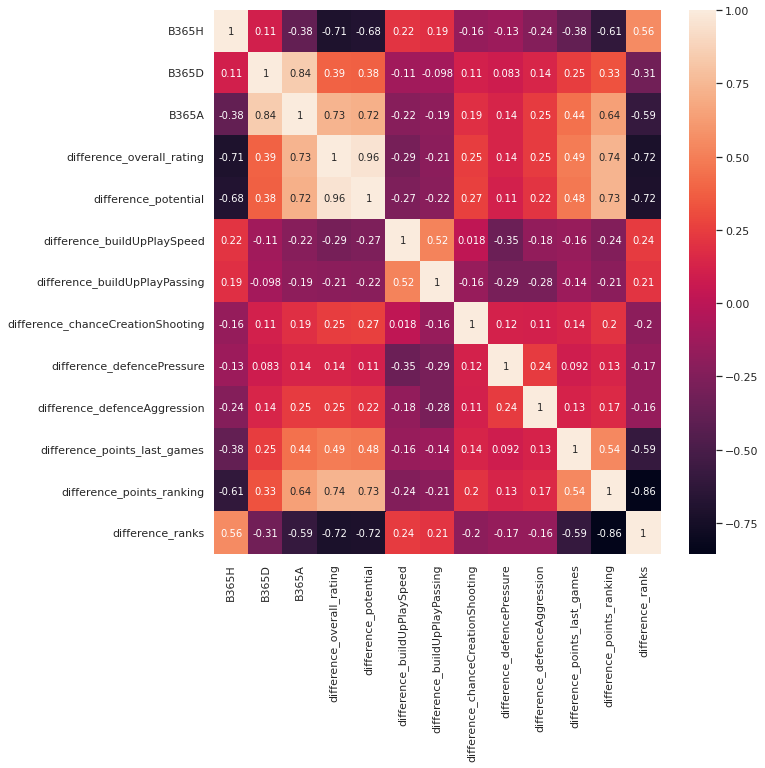

In [26]:
corr_matrix = df.loc[:, ['B365H','B365D','B365A','difference_overall_rating','difference_potential','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                         'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking','difference_ranks']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Mostly "Problematic":
# - overall_rating and B365H
# - overall_rating and B365A
# - difference_points_ranking and overall_rating
# - B356D and B365A

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519 entries, 0 to 1518
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 1519 non-null   int64         
 1   date                               1519 non-null   datetime64[ns]
 2   season                             1519 non-null   object        
 3   stage                              1519 non-null   int64         
 4   country_id                         1519 non-null   int64         
 5   Country_Name                       1519 non-null   object        
 6   league_id                          1519 non-null   int64         
 7   League_Name                        1519 non-null   object        
 8   home_team_api_id                   1519 non-null   int64         
 9   HT_long_name                       1519 non-null   object        
 10  away_team_api_id                   1

In [28]:
#corr_matrix = df.loc[df["Country_Name"] == "Italy", ['B365H','B365D','B365A','ratio_overall_rating','ratio_potential','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting','ratio_defencePressure','ratio_defenceAggression','difference_points_last_games']].corr()
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(corr_matrix, annot=True)
#plt.show()

In [29]:
#corr_matrix = df.loc[df["Country_Name"] == "Spain", ['B365H','B365D','B365A','ratio_overall_rating','ratio_potential','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting','ratio_defencePressure','ratio_defenceAggression','difference_points_last_games']].corr()
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(corr_matrix, annot=True)
#plt.show()

Mostly homewins, but the distribution is still ok, not too much skewed

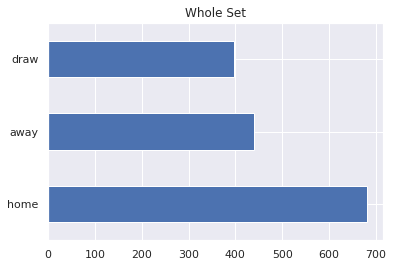

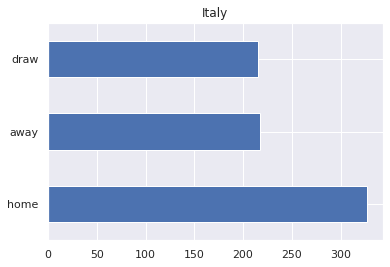

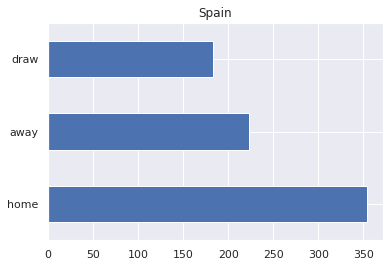

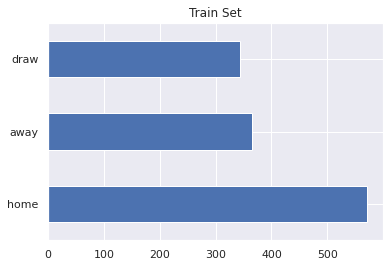

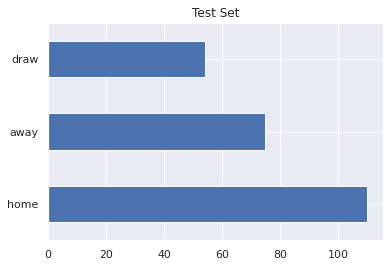

In [30]:
# Everything

plot_all = df['result'].value_counts()
plot_all.plot(kind='barh')
plt.title("Whole Set")
plt.show()

# Spain and Italy
plot_spain = df.loc[df.Country_Name == 'Italy'].iloc[:, 17].value_counts()
plot_spain.plot(kind='barh')
plt.title("Italy")
plt.show()

plot_spain = df.loc[df.Country_Name == 'Spain'].iloc[:, 17].value_counts()
plot_spain.plot(kind='barh')
plt.title("Spain")
plt.show()

# Test Set
plot_train = df.loc[df.stage <= 32].iloc[:, 17].value_counts()
plot_train.plot(kind='barh')
plt.title("Train Set")
plt.show()

# Train Set
plot_test = df.loc[df.stage > 32].iloc[:, 17].value_counts()
plot_test.plot(kind='barh')
plt.title("Test Set")
plt.show()

In [31]:
#fig, ax = plt.subplots(nrows=2, ncols=2)
#ax[0,0].bar(x[['result']], x[['count']])
#ax3 = df.loc[df["stage"] <= 32, ['result']].value_counts().plot(kind='barh')

Ratio below one means, tha rating of the home team is lower than the one from the away team

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


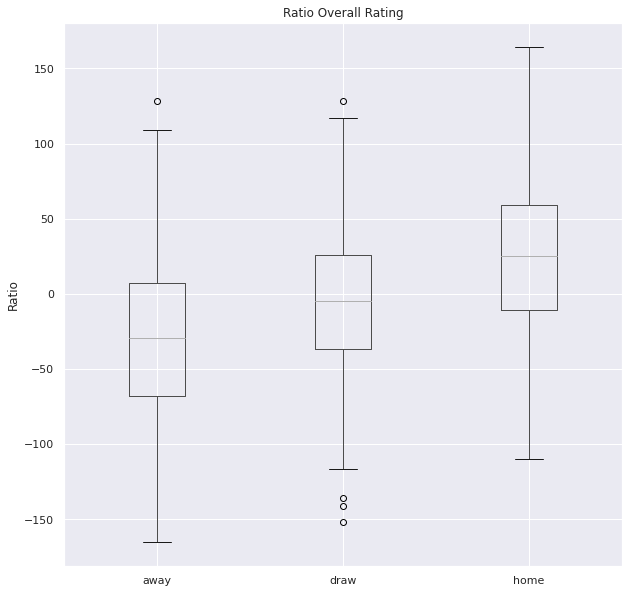

In [32]:
fig, ax = plt.subplots(1,1)
df.pivot(columns='result', values='difference_overall_rating').boxplot()
ax.set_title('Ratio Overall Rating')
ax.set_ylabel('Ratio')
fig.set_figheight(10)
fig.set_figwidth(10)
plt.show()

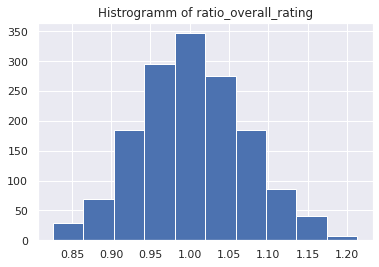

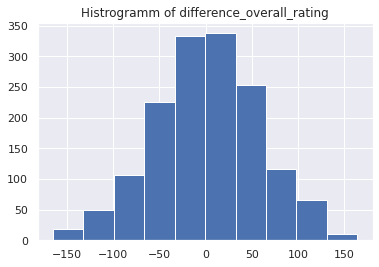

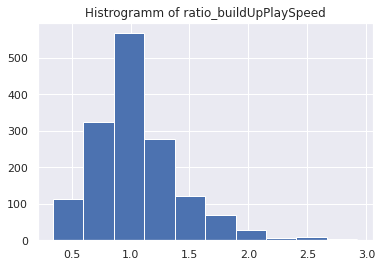

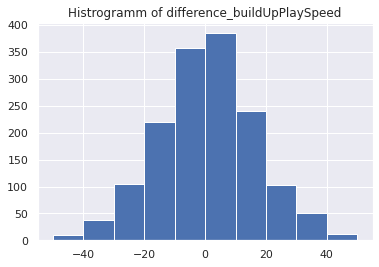

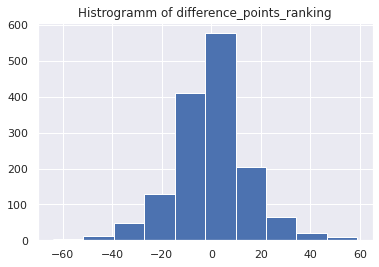

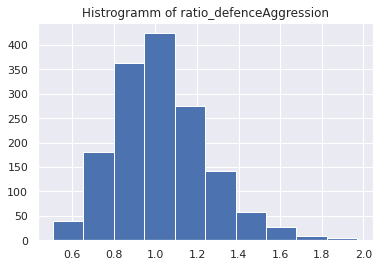

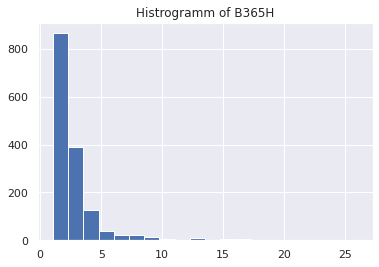

1.04


Index(['id', 'date', 'season', 'stage', 'country_id', 'Country_Name',
       'league_id', 'League_Name', 'home_team_api_id', 'HT_long_name',
       'away_team_api_id', 'AT_long_name', 'home_team_goal', 'away_team_goal',
       'B365H', 'B365D', 'B365A', 'result', 'home_points', 'away_points',
       'year', 'ratio_overall_rating', 'difference_overall_rating',
       'ratio_potential', 'difference_potential', 'ratio_buildUpPlaySpeed',
       'difference_buildUpPlaySpeed', 'ratio_buildUpPlayPassing',
       'difference_buildUpPlayPassing', 'ratio_chanceCreationShooting',
       'difference_chanceCreationShooting', 'ratio_defencePressure',
       'difference_defencePressure', 'ratio_defenceAggression',
       'difference_defenceAggression', 'last_games_points_home',
       'last_games_points_away', 'difference_points_last_games',
       'home_points_ranking', 'home_ranking', 'away_points_ranking',
       'away_ranking', 'difference_points_ranking', 'difference_ranks'],
      dtype='object

In [33]:
plt.hist(df.ratio_overall_rating, bins=10)
plt.title('Histrogramm of ratio_overall_rating')
plt.show()

plt.hist(df.difference_overall_rating, bins=10)
plt.title('Histrogramm of difference_overall_rating')
plt.show()

plt.hist(df.ratio_buildUpPlaySpeed, bins=10)
plt.title('Histrogramm of ratio_buildUpPlaySpeed')
plt.show()

plt.hist(df.difference_buildUpPlaySpeed, bins=10)
plt.title('Histrogramm of difference_buildUpPlaySpeed')
plt.show()

plt.hist(df.difference_points_ranking, bins=10)
plt.title('Histrogramm of difference_points_ranking')
plt.show()

plt.hist(df.ratio_defenceAggression, bins=10)
plt.title('Histrogramm of ratio_defenceAggression')
plt.show()

plt.hist(df.B365H, bins=20)
plt.title('Histrogramm of B365H')
plt.show()

print(min(df.B365H))

df.columns

If the hometeam wins, the odds are low, if the away team wins, the odds are high (meaning odds, that hometeam wins since are not favoured)$
- Actually fits the expectations

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


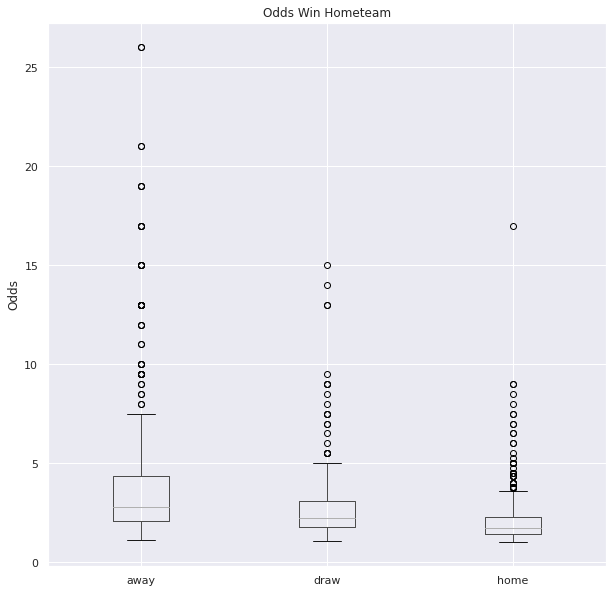

In [34]:
fig, ax = plt.subplots(1,1)
df.pivot(columns='result', values='B365H').boxplot()
ax.set_title('Odds Win Hometeam')
ax.set_ylabel(r'Odds')
fig.set_figheight(10)
fig.set_figwidth(10)
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


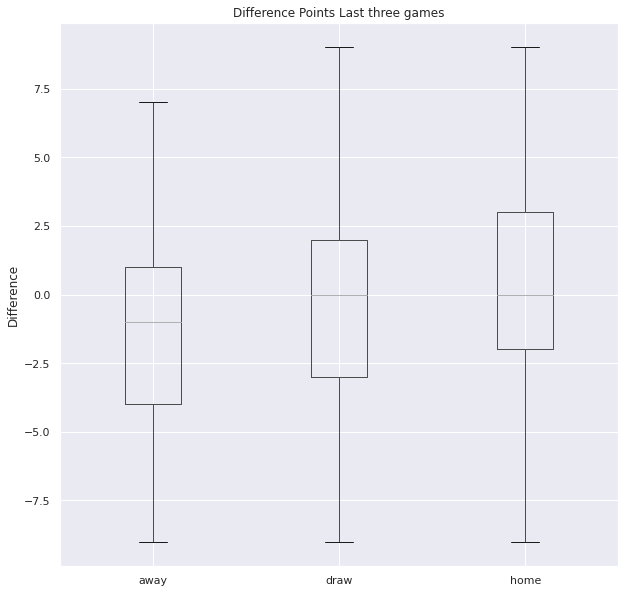

In [35]:
fig, ax = plt.subplots(1,1)
df.pivot(columns='result', values='difference_points_last_games').boxplot()
ax.set_title('Difference Points Last three games')
ax.set_ylabel(r'Difference')
fig.set_figheight(10)
fig.set_figwidth(10)
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


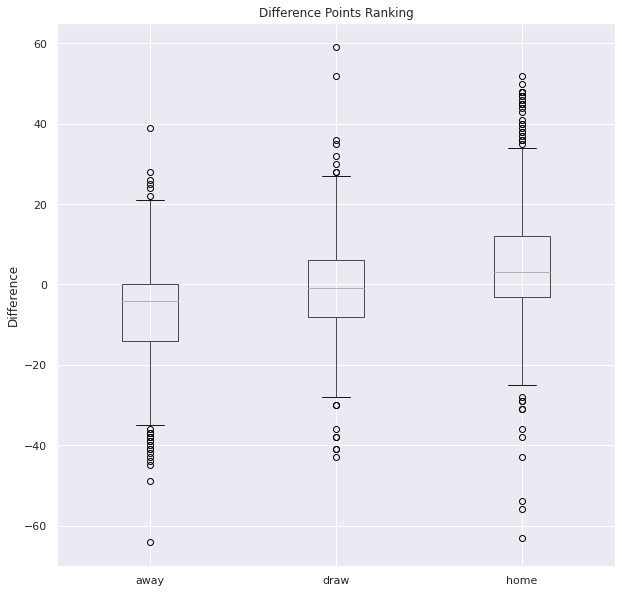

In [36]:
fig, ax = plt.subplots(1,1)
df.pivot(columns='result', values='difference_points_ranking').boxplot()
ax.set_title('Difference Points Ranking')
ax.set_ylabel(r'Difference')
fig.set_figheight(10)
fig.set_figwidth(10)
plt.show()

In [37]:
# Encoding Factor Country
df_dummies = pd.get_dummies(df['Country_Name'])
df_dummies.head()
df = df.join(df_dummies)
df.columns

Index(['id', 'date', 'season', 'stage', 'country_id', 'Country_Name',
       'league_id', 'League_Name', 'home_team_api_id', 'HT_long_name',
       'away_team_api_id', 'AT_long_name', 'home_team_goal', 'away_team_goal',
       'B365H', 'B365D', 'B365A', 'result', 'home_points', 'away_points',
       'year', 'ratio_overall_rating', 'difference_overall_rating',
       'ratio_potential', 'difference_potential', 'ratio_buildUpPlaySpeed',
       'difference_buildUpPlaySpeed', 'ratio_buildUpPlayPassing',
       'difference_buildUpPlayPassing', 'ratio_chanceCreationShooting',
       'difference_chanceCreationShooting', 'ratio_defencePressure',
       'difference_defencePressure', 'ratio_defenceAggression',
       'difference_defenceAggression', 'last_games_points_home',
       'last_games_points_away', 'difference_points_last_games',
       'home_points_ranking', 'home_ranking', 'away_points_ranking',
       'away_ranking', 'difference_points_ranking', 'difference_ranks',
       'Italy', 'Spa

####**Random Forest**

With Ratios (Not Used)

In [38]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting',
                                                            'ratio_defencePressure','ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['result']]

x_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35) , ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting','ratio_defencePressure',
                                    'ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35), ['result']]

x_test = df.loc[df["stage"] > 35 , ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting','ratio_defencePressure',
                                    'ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [39]:
print(len(x_train))
print(len(x_test))

1160
119


In [40]:
res = []
for estimators in [1,10,50,100]:
  for depth in [2,4,6,8]:
    rfc = ensemble.RandomForestClassifier(max_depth=4, n_estimators=estimators,)
    rfc = rfc.fit(x_train, y_train.values.ravel())
    print(f"Estimators: ", {estimators}, "Depth: ", {depth})
#    print("rfc training score : %.3f" % (rfc.score(x_train, y_train)))
    print("rfc test score : %.3f" % (rfc.score(x_validation, y_validation)))
    res.append(rfc.score(x_validation, y_validation))

Estimators:  {1} Depth:  {2}
rfc test score : 0.492
Estimators:  {1} Depth:  {4}
rfc test score : 0.508
Estimators:  {1} Depth:  {6}
rfc test score : 0.475
Estimators:  {1} Depth:  {8}
rfc test score : 0.508
Estimators:  {10} Depth:  {2}
rfc test score : 0.533
Estimators:  {10} Depth:  {4}
rfc test score : 0.533
Estimators:  {10} Depth:  {6}
rfc test score : 0.517
Estimators:  {10} Depth:  {8}
rfc test score : 0.517
Estimators:  {50} Depth:  {2}
rfc test score : 0.525
Estimators:  {50} Depth:  {4}
rfc test score : 0.508
Estimators:  {50} Depth:  {6}
rfc test score : 0.533
Estimators:  {50} Depth:  {8}
rfc test score : 0.500
Estimators:  {100} Depth:  {2}
rfc test score : 0.508
Estimators:  {100} Depth:  {4}
rfc test score : 0.517
Estimators:  {100} Depth:  {6}
rfc test score : 0.525
Estimators:  {100} Depth:  {8}
rfc test score : 0.517


In [41]:
sorted(res)

[0.475,
 0.49166666666666664,
 0.5,
 0.5083333333333333,
 0.5083333333333333,
 0.5083333333333333,
 0.5083333333333333,
 0.5166666666666667,
 0.5166666666666667,
 0.5166666666666667,
 0.5166666666666667,
 0.525,
 0.525,
 0.5333333333333333,
 0.5333333333333333,
 0.5333333333333333]

In [42]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting',
                                                            'ratio_defencePressure','ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['result']]
x_test = df.loc[df["stage"] > 35 , ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting','ratio_defencePressure',
                                    'ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [43]:
rfc = ensemble.RandomForestClassifier(max_depth=6, n_estimators=100,)
rfc = rfc.fit(x_train, y_train.values.ravel())
print(f"Estimators: ", {estimators})
print("rfc training score : %.3f" % (rfc.score(x_train, y_train)))
print("rfc test score : %.3f" % (rfc.score(x_test, y_test)))

Estimators:  {100}
rfc training score : 0.654
rfc test score : 0.546


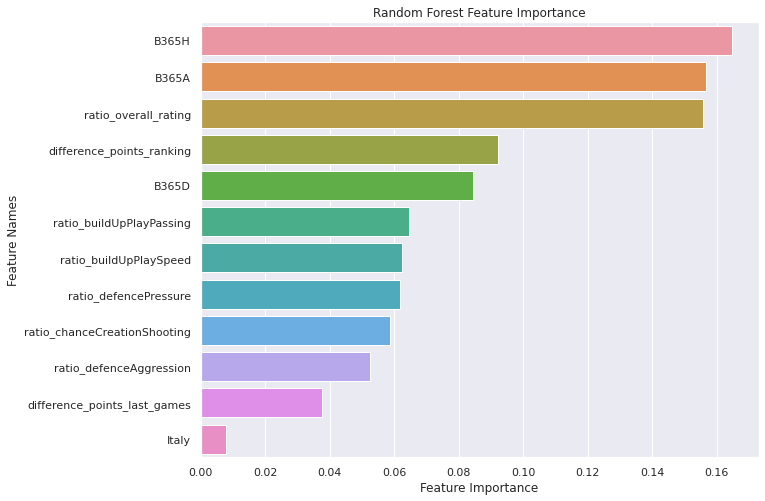

In [44]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + ' Feature Importance')
  plt.xlabel('Feature Importance')
  plt.ylabel('Feature Names')

plot_feature_importance(rfc.feature_importances_,x_train.columns,'Random Forest')

####Confusion Matrix

[[17  4 19]
 [ 7  0 16]
 [ 7  1 48]]
rfc test score : 0.546


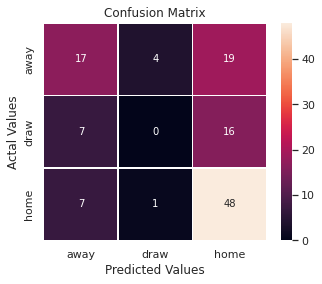

In [45]:
y_pred = rfc.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
y_test
print(cm)
print("rfc test score : %.3f" % (rfc.score(x_test, y_test)))

cm_df = pd.DataFrame(cm,
                     index = ['away','draw','home'], 
                     columns = ['away','draw','home'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, linewidth=.5)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1807b71220>,
      dtype=object)

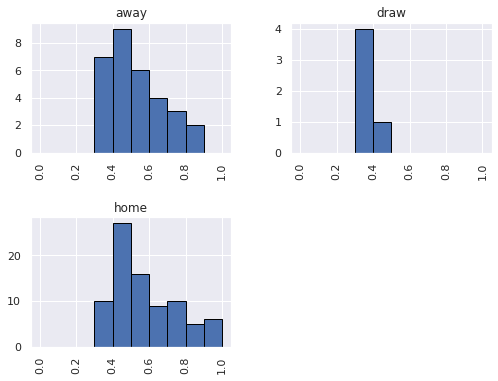

In [46]:
y_pred_prob = rfc.predict_proba(x_test)
y_pred = rfc.predict(x_test)
y_pred_prob_max = np.amax(y_pred_prob, axis = 1)
df_pred = pd.DataFrame(
    {'probability': y_pred_prob_max,
     'label': y_pred
    })

df_pred['label_true'] = y_test['result'].values

df_pred['probability'].hist(by=df_pred['label'],
                            bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                            edgecolor='black', 
                            figsize = (8,6)) 

0.8461538461538461


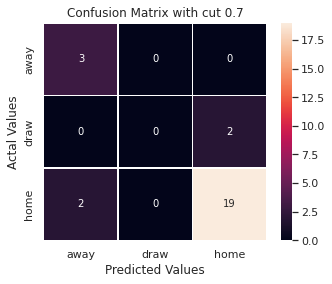

0.8461538461538461


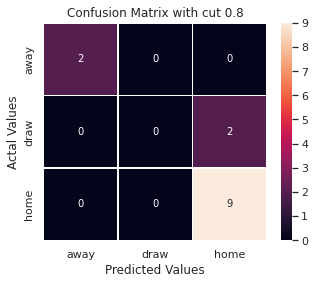

In [47]:
for cut in [0.7,0.8]:

  y_pred_prob = df_pred.loc[df_pred["probability"] > cut, ['label']]
  y_test_prob = df_pred.loc[df_pred["probability"] > cut, ['label_true']]
  print(accuracy_score(y_test_prob, y_pred_prob))

  cm = confusion_matrix(y_test_prob, y_pred_prob)

  cm_df = pd.DataFrame(cm,
                       index = ['away','draw','home'], 
                       columns = ['away','draw','home'])

  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True, linewidth=.5)
  plt.title(f'Confusion Matrix with cut {cut}')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

####**Logistic Regression**








In [48]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting',
                                                            'ratio_defencePressure','ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['result']]

x_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35) , ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting','ratio_defencePressure',
                                    'ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35), ['result']]

x_test = df.loc[df["stage"] > 35 , ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting','ratio_defencePressure',
                                    'ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [49]:
for multi_class in ('multinomial', 'ovr'):
  clf = linear_model.LogisticRegression(solver='sag', max_iter=100, multi_class=multi_class)
  clf.fit(x_train, y_train.values.ravel())
  print("clf training score : %.3f" % (clf.score(x_train, y_train.values.ravel())))
  print("clf test score : %.3f" % (clf.score(x_validation, y_validation.values.ravel())))

clf training score : 0.529
clf test score : 0.508
clf training score : 0.531
clf test score : 0.508


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [50]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting',
                                                            'ratio_defencePressure','ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['result']]
x_test = df.loc[df["stage"] > 35 , ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting','ratio_defencePressure',
                                    'ratio_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [51]:
clf = linear_model.LogisticRegression(solver='sag', max_iter=100, multi_class='ovr')
clf.fit(x_train, y_train.values.ravel())
print("clf training score : %.3f" % (clf.score(x_train, y_train.values.ravel())))
print("clf test score : %.3f" % (clf.score(x_test, y_test.values.ravel())))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


clf training score : 0.528
clf test score : 0.555


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


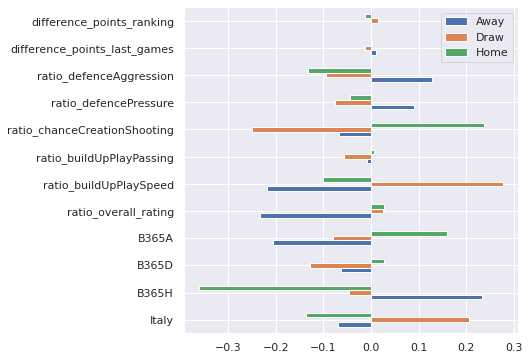

In [52]:
index = ['Italy','B365H','B365D','B365A','ratio_overall_rating','ratio_buildUpPlaySpeed','ratio_buildUpPlayPassing','ratio_chanceCreationShooting','ratio_defencePressure','ratio_defenceAggression','difference_points_last_games','difference_points_ranking']
df_draw = pd.DataFrame({'Away': clf.coef_[0],
                   'Draw': clf.coef_[1],
                   'Home': clf.coef_[2]}, 
                  index=index)
ax = df_draw.plot.barh(figsize=(6,6))

[[17  3 20]
 [ 6  1 16]
 [ 6  2 48]]
clf test score : 0.555


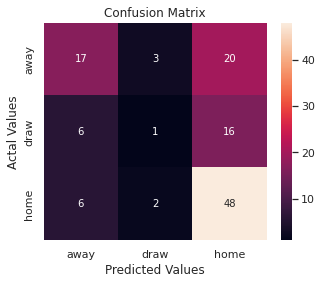

In [53]:
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print("clf test score : %.3f" % (clf.score(x_test, y_test.values.ravel())))

cm_df = pd.DataFrame(cm,
                     index = ['away','draw','home'], 
                     columns = ['away','draw','home'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1807fc4160>,
      dtype=object)

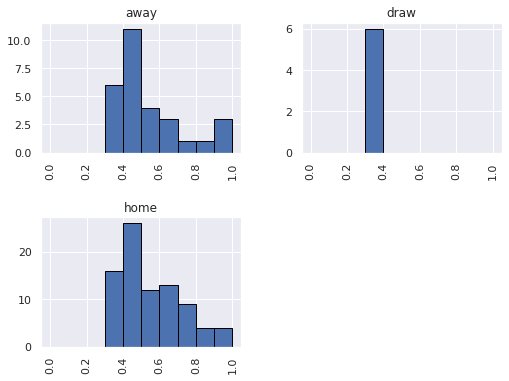

In [54]:
y_pred_prob = clf.predict_proba(x_test)
y_pred = clf.predict(x_test)
y_pred_prob_max = np.amax(y_pred_prob, axis = 1)
df_pred = pd.DataFrame(
    {'probability': y_pred_prob_max,
     'label': y_pred
    })

df_pred['label_true'] = y_test['result'].values

df_pred['probability'].hist(by=df_pred['label'],
                            bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                            edgecolor='black', 
                            figsize = (8,6)) 

0.8636363636363636


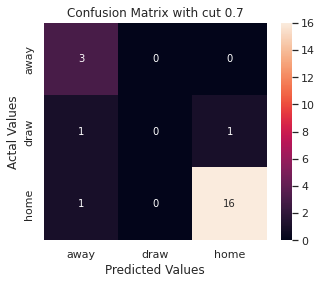

0.8333333333333334


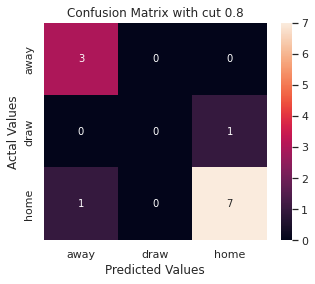

In [55]:
for cut in [0.7,0.8]:

  y_pred_prob = df_pred.loc[df_pred["probability"] > cut, ['label']]
  y_test_prob = df_pred.loc[df_pred["probability"] > cut, ['label_true']]
  print(accuracy_score(y_test_prob, y_pred_prob))

  cm = confusion_matrix(y_test_prob, y_pred_prob)

  cm_df = pd.DataFrame(cm,
                       index = ['away','draw','home'], 
                       columns = ['away','draw','home'])

  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title(f'Confusion Matrix with cut {cut}')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

####**Testing with differences & correlation eliminations**

In [56]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                                            'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['result']]

x_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35) , ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                                                  'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35), ['result']]

x_test = df.loc[df["stage"] > 35 , ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',        
                                    'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [57]:
res = []
for estimators in [1,10,50,100]:
  for depth in [2,4,6,8]:
    rfc = ensemble.RandomForestClassifier(max_depth=4, n_estimators=estimators,)
    rfc = rfc.fit(x_train, y_train.values.ravel())
    print(f"Estimators: ", {estimators}, "Depth: ", {depth})
#    print("rfc training score : %.3f" % (rfc.score(x_train, y_train)))
    print("rfc test score : %.3f" % (rfc.score(x_validation, y_validation)))
    res.append(rfc.score(x_validation, y_validation))

Estimators:  {1} Depth:  {2}
rfc test score : 0.467
Estimators:  {1} Depth:  {4}
rfc test score : 0.467
Estimators:  {1} Depth:  {6}
rfc test score : 0.467
Estimators:  {1} Depth:  {8}
rfc test score : 0.508
Estimators:  {10} Depth:  {2}
rfc test score : 0.533
Estimators:  {10} Depth:  {4}
rfc test score : 0.517
Estimators:  {10} Depth:  {6}
rfc test score : 0.542
Estimators:  {10} Depth:  {8}
rfc test score : 0.500
Estimators:  {50} Depth:  {2}
rfc test score : 0.525
Estimators:  {50} Depth:  {4}
rfc test score : 0.517
Estimators:  {50} Depth:  {6}
rfc test score : 0.525
Estimators:  {50} Depth:  {8}
rfc test score : 0.533
Estimators:  {100} Depth:  {2}
rfc test score : 0.517
Estimators:  {100} Depth:  {4}
rfc test score : 0.500
Estimators:  {100} Depth:  {6}
rfc test score : 0.525
Estimators:  {100} Depth:  {8}
rfc test score : 0.508


In [58]:
sorted(res)

[0.4666666666666667,
 0.4666666666666667,
 0.4666666666666667,
 0.5,
 0.5,
 0.5083333333333333,
 0.5083333333333333,
 0.5166666666666667,
 0.5166666666666667,
 0.5166666666666667,
 0.525,
 0.525,
 0.525,
 0.5333333333333333,
 0.5333333333333333,
 0.5416666666666666]

In [59]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                                            'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['result']]
x_test = df.loc[df["stage"] > 35, ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                    'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [60]:
rfc = ensemble.RandomForestClassifier(max_depth=6, n_estimators=100,)
rfc = rfc.fit(x_train, y_train.values.ravel())
print(f"Estimators: ", {estimators})
print("rfc training score : %.3f" % (rfc.score(x_train, y_train)))
print("rfc test score : %.3f" % (rfc.score(x_test, y_test)))

Estimators:  {100}
rfc training score : 0.655
rfc test score : 0.563


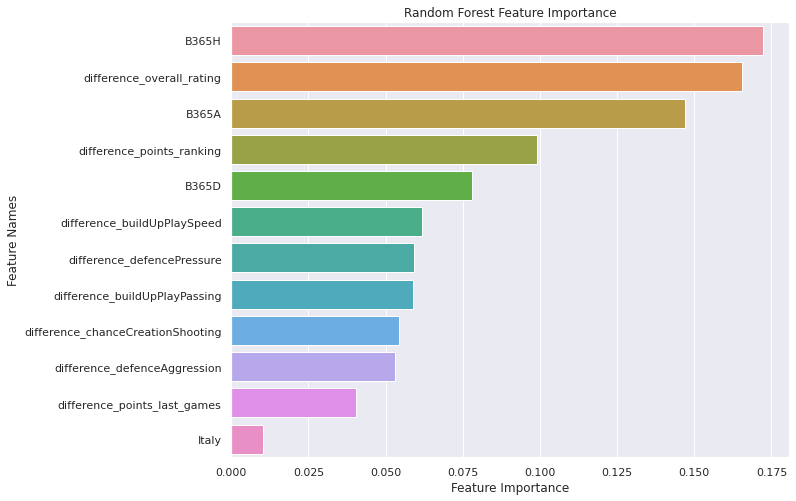

In [61]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + ' Feature Importance')
  plt.xlabel('Feature Importance')
  plt.ylabel('Feature Names')

plot_feature_importance(rfc.feature_importances_,x_train.columns,'Random Forest')

[[17  4 19]
 [ 7  0 16]
 [ 6  0 50]]
rfc test score : 0.563


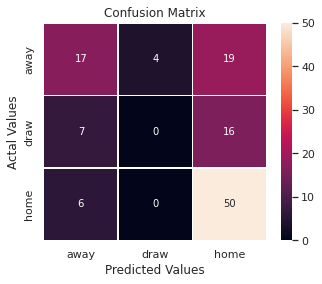

In [62]:
y_pred = rfc.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("rfc test score : %.3f" % (rfc.score(x_test, y_test)))

cm_df = pd.DataFrame(cm,
                     index = ['away','draw','home'], 
                     columns = ['away','draw','home'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, linewidth=.5)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18078ea250>,
      dtype=object)

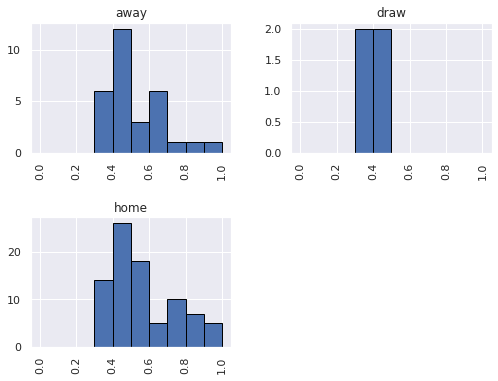

In [63]:
y_pred_prob = rfc.predict_proba(x_test)
y_pred = rfc.predict(x_test)
y_pred_prob_max = np.amax(y_pred_prob, axis = 1)
df_pred = pd.DataFrame(
    {'probability': y_pred_prob_max,
     'label': y_pred
    })

df_pred['label_true'] = y_test['result'].values

df_pred['probability'].hist(by=df_pred['label'],
                            bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                            edgecolor='black', 
                            figsize = (8,6)) 

0.84


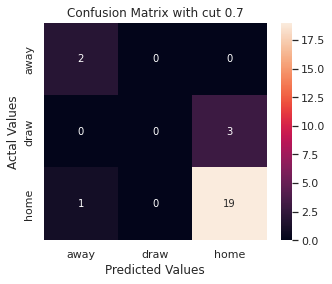

0.8571428571428571


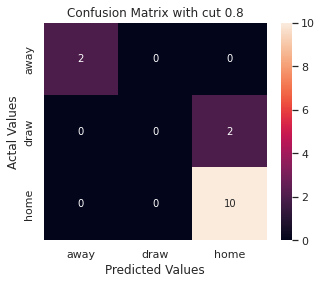

In [64]:
for cut in [0.7,0.8]:

  y_pred_prob = df_pred.loc[df_pred["probability"] > cut, ['label']]
  y_test_prob = df_pred.loc[df_pred["probability"] > cut, ['label_true']]
  print(accuracy_score(y_test_prob, y_pred_prob))

  cm = confusion_matrix(y_test_prob, y_pred_prob)

  cm_df = pd.DataFrame(cm,
                       index = ['away','draw','home'], 
                       columns = ['away','draw','home'])

  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title(f'Confusion Matrix with cut {cut}')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

####**Logistic with differences and correlated variables**

In [65]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                                            'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['result']]

x_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35) , ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                                                  'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35), ['result']]

x_test = df.loc[df["stage"] > 35 , ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',        
                                    'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [66]:
for multi_class in ('multinomial', 'ovr'):
  clf = linear_model.LogisticRegression(solver='sag', max_iter=100, multi_class=multi_class)
  clf.fit(x_train, y_train.values.ravel())
  print("clf training score : %.3f" % (clf.score(x_validation, y_validation.values.ravel())))
  print("clf test score : %.3f" % (clf.score(x_validation, y_validation.values.ravel())))

clf training score : 0.492
clf test score : 0.492
clf training score : 0.500
clf test score : 0.500


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [67]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                                            'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['result']]
x_test = df.loc[df["stage"] > 35, ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                    'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [68]:
clf = linear_model.LogisticRegression(solver='sag', max_iter=100, multi_class='ovr')
clf.fit(x_train, y_train.values.ravel())
print("clf training score : %.3f" % (clf.score(x_validation, y_validation.values.ravel())))
print("clf test score : %.3f" % (clf.score(x_validation, y_validation.values.ravel())))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


clf training score : 0.533
clf test score : 0.533


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


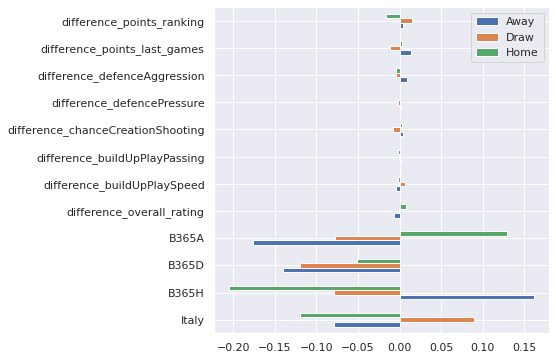

In [69]:
index =  ['Italy','B365H','B365D','B365A','difference_overall_rating','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
          'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']
df_draw = pd.DataFrame({'Away': clf.coef_[0],
                        'Draw': clf.coef_[1],
                        'Home': clf.coef_[2]}, 
                         index=index)
ax = df_draw.plot.barh(figsize=(6,6))

[[19  3 18]
 [ 7  0 16]
 [ 7  1 48]]
clf test score : 0.563


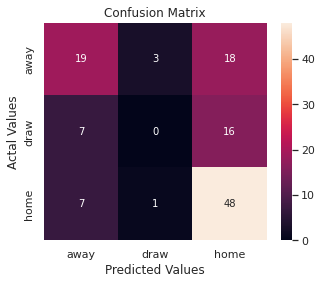

In [70]:
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print("clf test score : %.3f" % (clf.score(x_test, y_test.values.ravel())))

cm_df = pd.DataFrame(cm,
                     index = ['away','draw','home'], 
                     columns = ['away','draw','home'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18077935e0>,
      dtype=object)

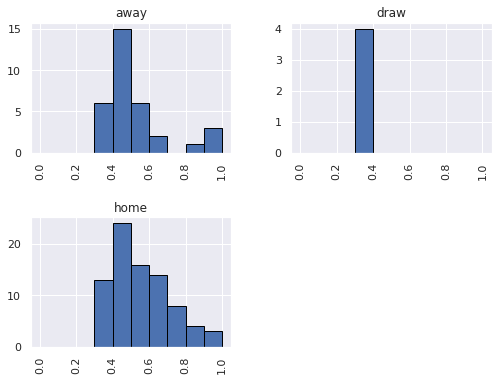

In [71]:
y_pred_prob = clf.predict_proba(x_test)
y_pred = clf.predict(x_test)
y_pred_prob_max = np.amax(y_pred_prob, axis = 1)
df_pred = pd.DataFrame(
    {'probability': y_pred_prob_max,
     'label': y_pred
    })

df_pred['label_true'] = y_test['result'].values

df_pred['probability'].hist(by=df_pred['label'],
                            bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                            edgecolor='black', 
                            figsize = (8,6)) 

0.8947368421052632


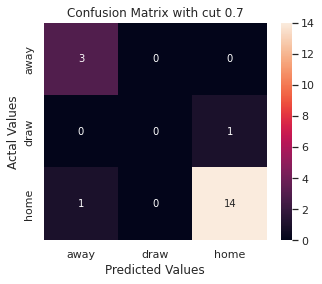

0.8181818181818182


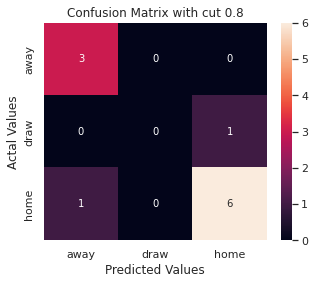

In [72]:
for cut in [0.7,0.8]:

  y_pred_prob = df_pred.loc[df_pred["probability"] > cut, ['label']]
  y_test_prob = df_pred.loc[df_pred["probability"] > cut, ['label_true']]
  print(accuracy_score(y_test_prob, y_pred_prob))

  cm = confusion_matrix(y_test_prob, y_pred_prob)

  cm_df = pd.DataFrame(cm,
                       index = ['away','draw','home'], 
                       columns = ['away','draw','home'])

  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title(f'Confusion Matrix with cut {cut}')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

####**Logistic Regression without correlated variables**

In [73]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['Italy','B365H','B365D','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                                            'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 32), ['result']]

x_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35) , ['Italy','B365H','B365D','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                                                  'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_validation = df.loc[(df["stage"] > 32) & (df["stage"] <= 35), ['result']]

x_test = df.loc[df["stage"] > 35 , ['Italy','B365H','B365D','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                    'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [74]:
for multi_class in ('multinomial', 'ovr'):
  clf = linear_model.LogisticRegression(solver='sag', max_iter=100, multi_class=multi_class)
  clf.fit(x_train, y_train.values.ravel())
  print("clf training score : %.3f" % (clf.score(x_validation, y_validation.values.ravel())))
  print("clf test score : %.3f" % (clf.score(x_validation, y_validation.values.ravel())))

clf training score : 0.492
clf test score : 0.492
clf training score : 0.500
clf test score : 0.500


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [75]:
x_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['Italy','B365H','B365D','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                                            'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_train = df.loc[(df["stage"] >= 4) & (df["stage"] <= 35), ['result']]
x_test = df.loc[df["stage"] > 35 , ['Italy','B365H','B365D','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
                                    'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']]
y_test = df.loc[df["stage"] > 35, ['result']]

In [76]:
clf = linear_model.LogisticRegression(solver='sag', max_iter=100, multi_class='ovr')
clf.fit(x_train, y_train.values.ravel())
print("clf training score : %.3f" % (clf.score(x_test, y_test.values.ravel())))
print("clf test score : %.3f" % (clf.score(x_test, y_test.values.ravel())))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


clf training score : 0.555
clf test score : 0.555


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


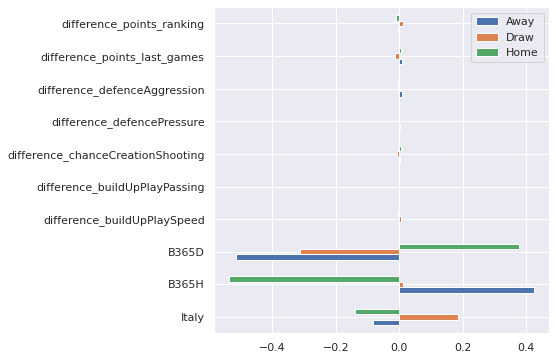

In [77]:
index =  ['Italy','B365H','B365D','difference_buildUpPlaySpeed','difference_buildUpPlayPassing','difference_chanceCreationShooting',
          'difference_defencePressure','difference_defenceAggression','difference_points_last_games','difference_points_ranking']
df_draw = pd.DataFrame({'Away': clf.coef_[0],
                        'Draw': clf.coef_[1],
                        'Home': clf.coef_[2]}, 
                         index=index)
ax = df_draw.plot.barh(figsize=(6,6))

[[15  1 24]
 [ 6  0 17]
 [ 4  1 51]]
clf test score : 0.555


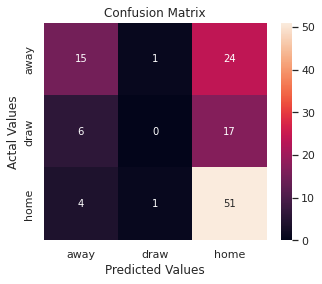

In [78]:
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
y_test
print(cm)
print("clf test score : %.3f" % (clf.score(x_test, y_test.values.ravel())))

cm_df = pd.DataFrame(cm,
                     index = ['away','draw','home'], 
                     columns = ['away','draw','home'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1807ea6220>,
      dtype=object)

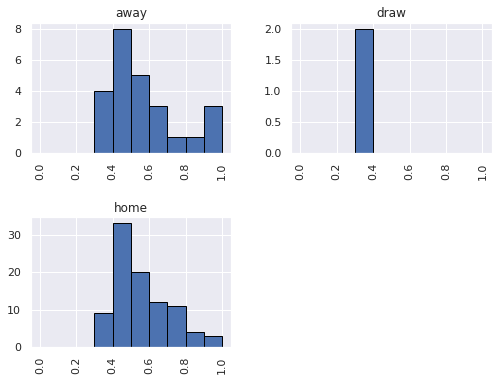

In [79]:
y_pred_prob = clf.predict_proba(x_test)
y_pred = clf.predict(x_test)
y_pred_prob_max = np.amax(y_pred_prob, axis = 1)
df_pred = pd.DataFrame(
    {'probability': y_pred_prob_max,
     'label': y_pred
    })

df_pred['label_true'] = y_test['result'].values

df_pred['probability'].hist(by=df_pred['label'],
                            bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                            edgecolor='black', 
                            figsize = (8,6)) 

0.8695652173913043


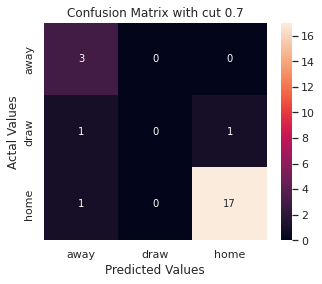

0.9090909090909091


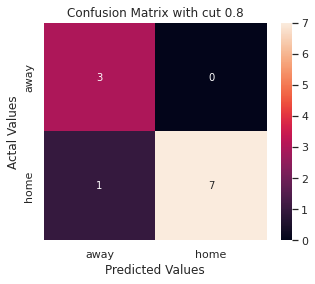

In [80]:
for cut in [0.7,0.8]:

  y_pred_prob = df_pred.loc[df_pred["probability"] > cut, ['label']]
  y_test_prob = df_pred.loc[df_pred["probability"] > cut, ['label_true']]
  print(accuracy_score(y_test_prob, y_pred_prob))

  cm = confusion_matrix(y_test_prob, y_pred_prob)

  if cm.shape == (2,2):
    cm_df = pd.DataFrame(cm,
                         index = ['away','home'], 
                         columns = ['away','home'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title(f'Confusion Matrix with cut {cut}')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
  
  else:
    cm_df = pd.DataFrame(cm,
                         index = ['away','draw','home'], 
                         columns = ['away','draw','home'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title(f'Confusion Matrix with cut {cut}')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

#### **Explanation columns**

*   B365H to BSA are the beeting odds for
    *   H Odds for Home Win
    *   D Odds for Draw
    *   A Odds for Away Win
*   Goal, shoton, shotoff etc. are not available for Switzerland but e.g. Italy has strange values in there (text)
    * Need?
    * Maybe problems with data gathering (looks like scraper was not usefule)
    * Those values are usually not available prior to game
    * Could only use as trailing values over past games
* home_player_Y
  * Values from 1 to 11, should be the y-axis values to determine the position (?)
* home_player_X
  * Values from 1 to 8, should be the x-axis values to dtermine the postion (?)
  * Use X_Y to determine staring formation -> are there names? Defensive, offensive etc.?


#### **Comments**

*   Odds for Switzland are barley available
    * Needed? Would have to take an other League then (e.g. Italy)
*   Some Information won't be available prior to a game (e.g. possesion or goals)
    * Maybe use historic values from e.g. last 5 games or last encounter (or similar teams)

*   

#### **Used Columns and reason**

* home_team_goal
* away_team_goal
  * Determine the outcome: Home_Win, Away_Win, Draw

Problem: seems to have some lack of data, especially for things like possession etc. ARE THOSE IMPORTANT for trialing values?

#### **Enhancement**

Could enhance the dataset with metrics for 
* the players 
* the team (if not correlated to playsers) -> but then in relation together
* trailing values about winning, losing and draws
* trailing values about direct competition (might be to less data per season)
* Temperature, weather condition

Better do a loop in Python to compute, SQL might be to tedious

**Big question: how does the final set looks like? Prediction per Team?**

E.g. Team, Home (Yes / No), Opponent, Team Score, Opponent Score
or like this dataset?
-> If taken apart, there are always two predictions which schould yield to the same conclusion. E.g. YB - Basel:
- Once Team is YB with Home Yes
- Once Team is Basel with Home No etc.

Does this make sense?
What are the differences?

####**Idea model**

Better go with the first Model, 1 Record = 1 Match instead of 1 Record = 1 Team from the match (would double the Records).

Would be interesting, if there are two Record per Match, if they predict the same, could be consent, if not, no consent. However, all is just the opposite of the other. So better stick with the first one.

Basic idea is not to predict at the beginning of the season, but rather the second half (more data is available about winning and losing). But then there is not much training data, would need more seasons (why not)
-> use 3 seasons



####**Team and Player Attributes**

Idea is to make Ratios out of those numbers, instead of using plain numbers.

Have to check, how those numbers are. Might be changing overtime (would be good, but don't think so since are from FIFA Game and therefore fixed). 

So, for each record there are two teams (Home and Away).

Join by ID and Date. Best taking the season as reference.

Problem, that Teams change from one to other season?
-> Only, if the Team Name is used...